In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pysr import PySRRegressor, TemplateExpressionSpec

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Multitask

In [4]:
def custom_loss(dataset_size, n_datasets):
    return f"""
    import Pkg
    Pkg.add("Optim")
    Pkg.add("DynamicExpressions")
    
    using SymbolicRegression
    using Optim
    using DynamicExpressions: 
        count_scalar_constants
    
    function multitask_loss(tree, dataset:: Dataset{{T, L}}, options)::L where {{T, L}}
        function my_eval(tree, x_, y_, params, options)
            
            id = 1
            buf = [tree]
    
            while !isempty(buf) 
                elem = pop!(buf)  
    
                if elem.degree == 0 && elem.constant
                    elem.val = params[id]
                    id += 1
                end
            end
            
            prediction, flag = eval_tree_array(tree, x_, options)
            if !flag
                return Inf
            end
            prediction_ = Bool.(prediction .>= 0.5)
            y_ = Bool.(y_)
            not_accuracy = sum(prediction_ .!= y_) / length(prediction)
            
            return not_accuracy
        end
        
        num_params = count_scalar_constants(tree)
        
        if num_params == 0
            return L(Inf)
        end
    
        dataset_size = {dataset_size}
        n_datasets = {n_datasets}
        
        datasets = []
        for i in 1:n_datasets
            X = dataset.X[:, (i - 1) * dataset_size + 1: i * dataset_size]
            y = dataset.y[(i - 1) * dataset_size + 1: i * dataset_size]
            push!(datasets, (X, y))
        end
        
        total_loss = 0.0
        initial_params = ones(num_params)
        for subds in datasets        
            res = Optim.optimize(p -> my_eval(tree, subds[1], subds[2], p, options), initial_params)
            total_loss += Optim.minimum(res)
        end
        return total_loss
    end
    """

In [5]:
options = dict(
    unary_operators=["exp"],
    binary_operators=["+", "*"],
    model_selection="best"
)

In [9]:
n_samples = 100
n_datasets = [1, 2, 5, 10, 15]

In [8]:
X_all, y_all = [], [] 
for i in range(20):
    X, y = make_circles(n_samples=n_samples, noise=0.1, factor=0.4)
    
    if i % 5 == 1:
      X[:, 0] += i
      X[:, 1] += i
    elif i % 5 == 2:
      X[:, 0] += i
      X[:, 1] -= i
    elif i % 5 == 3:
      X[:, 0] -= i
      X[:, 1] -= i
    elif i % 5 == 4:
      X[:, 0] -= i
      X[:, 1] += i
    else:
        continue

    if len(X_all) == 0:
        X_all = X
        y_all = y
    else:
        X_all = np.vstack([X_all, X])
        y_all = np.hstack([y_all, y])
print("Number of datasets:", X_all.shape[0] // n_samples)

Number of datasets: 16


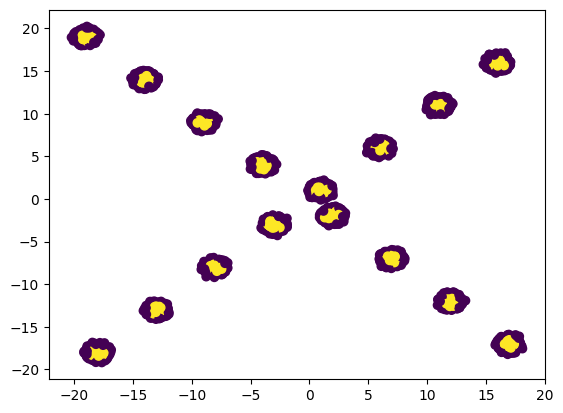

In [10]:
plt.scatter(X_all[:, 0], X_all[:, 1], c=y_all)

In [11]:
models = []
accuracies = []

for n_dataset in n_datasets:
    X_part = X_all[:n_samples * n_dataset, :]
    y_part = y_all[:n_samples * n_dataset]

    model = PySRRegressor(
        niterations=100,
        loss_function=custom_loss(dataset_size=n_samples, n_datasets=n_dataset),
        verbosity=0,
        **options
    )

    model.fit(X_part, y_part)
    print("Model: ", model.sympy().simplify())
    models.append(model.sympy().simplify())
    
    y_pred = model.predict(X_part)
    y_pred = (y_pred >= 0.5).astype(int)
    accuracy = accuracy_score(y_part, y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy on {n_dataset} datasets: {accuracy:.4f}")
    print("------------------------------------------------")

   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`


Model:  x1*exp(x0*(1.9527245 - 0.98840153*x0) - 1.1814971*x1)
Accuracy on 1 datasets: 1.0000
------------------------------------------------


   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`


Model:  0.43544558*x0*(x1**2 - 2.0481443)*(x1*(x0 - 2.3083427) + 0.5404669)*exp(1.8318808*x0*(x0 + x1))
Accuracy on 2 datasets: 0.9850
------------------------------------------------


   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`


Model:  (x1 + 2.4470067)*(x1*(x0 - 0.9165537*x1) + 1.3153068)*(x0 + x1 - 0.9165537)
Accuracy on 5 datasets: 0.7460
------------------------------------------------


   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`


Model:  (-0.9163269*x0 + x1)*(x1 + (x0 - 0.9163269*x1)*(x0 + x1)**2) + 2.8982387
Accuracy on 10 datasets: 0.7870
------------------------------------------------


   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pyjuliapkg/Project.toml`
  No Changes to `~/.julia/environments/pyjuliapkg/Manifest.toml`


Model:  (x0 + (-1.0032767*x0 + x1)*(x0 - 0.999774*x1)*(x0 + x1 - 0.6585562))*(x0 + x1 + 0.73337114)
Accuracy on 15 datasets: 0.8167
------------------------------------------------


---